In [1]:
import os
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import data

In [2]:
# Initialize dictionaries to store accumulated metrics
method_metrics = defaultdict(lambda: defaultdict(list))

# Folder path containing the .pkl files
folder_path = './metrics_outliers/'

# Iterate through files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.pkl'):
        # Parse method and p value from file name
        method, floor_p = file_name.split('_')[0], file_name.split('_')[2]
        p_value = int(floor_p[1:-4])
        
        # Load pickle file and extract metrics dictionary
        with open(os.path.join(folder_path, file_name), 'rb') as file:
            ad_metrics = pickle.load(file)
        
        # Accumulate metrics for each method and p value
        for metric, value in ad_metrics.items():
             method_metrics[(method, p_value)][metric].append(value)


In [3]:
# Calculate average metrics for each method and p value
average_metrics = defaultdict(lambda: defaultdict(float))

for method_p, metrics in method_metrics.items():
    method, p_value = method_p
    for metric, values in metrics.items():
        average_metrics[(method, p_value)][metric] = sum(values) / len(values)

In [4]:
# Print or store the average metrics
# for method_p, metrics in average_metrics.items():
#     method, p_value = method_p
#     print(f"Method: {method}, p: {p_value}")
#     for metric, value in metrics.items():
#         print(f"{metric}: {value}")

In [5]:
sorted_keys = sorted(average_metrics.keys(), key=lambda x: x[1])

sorted_metrics = {}

for key in sorted_keys:
    sorted_metrics[key] = average_metrics[key]

# visualize metrics

## prediction scores

In [7]:
metric_names = sorted(set(metric for method, p in sorted_metrics.keys() for metric in sorted_metrics[method, p].keys() 
                          if metric not in ['Confusion Matrix', 'FPR', 'TPR', 'ROC AUC']))
method_names = ['ensemble', 'kmeans', 'dbscan', 'ooc']

In [11]:
# Create subplots for each metric
num_rows = 4  # number of rows
num_cols = 3  # number of columns
method_label_mapping = {
    'ooc': 'OOC',
    'dbscan': 'DBSCAN',
    'ensemble': 'EIF-FL'
}

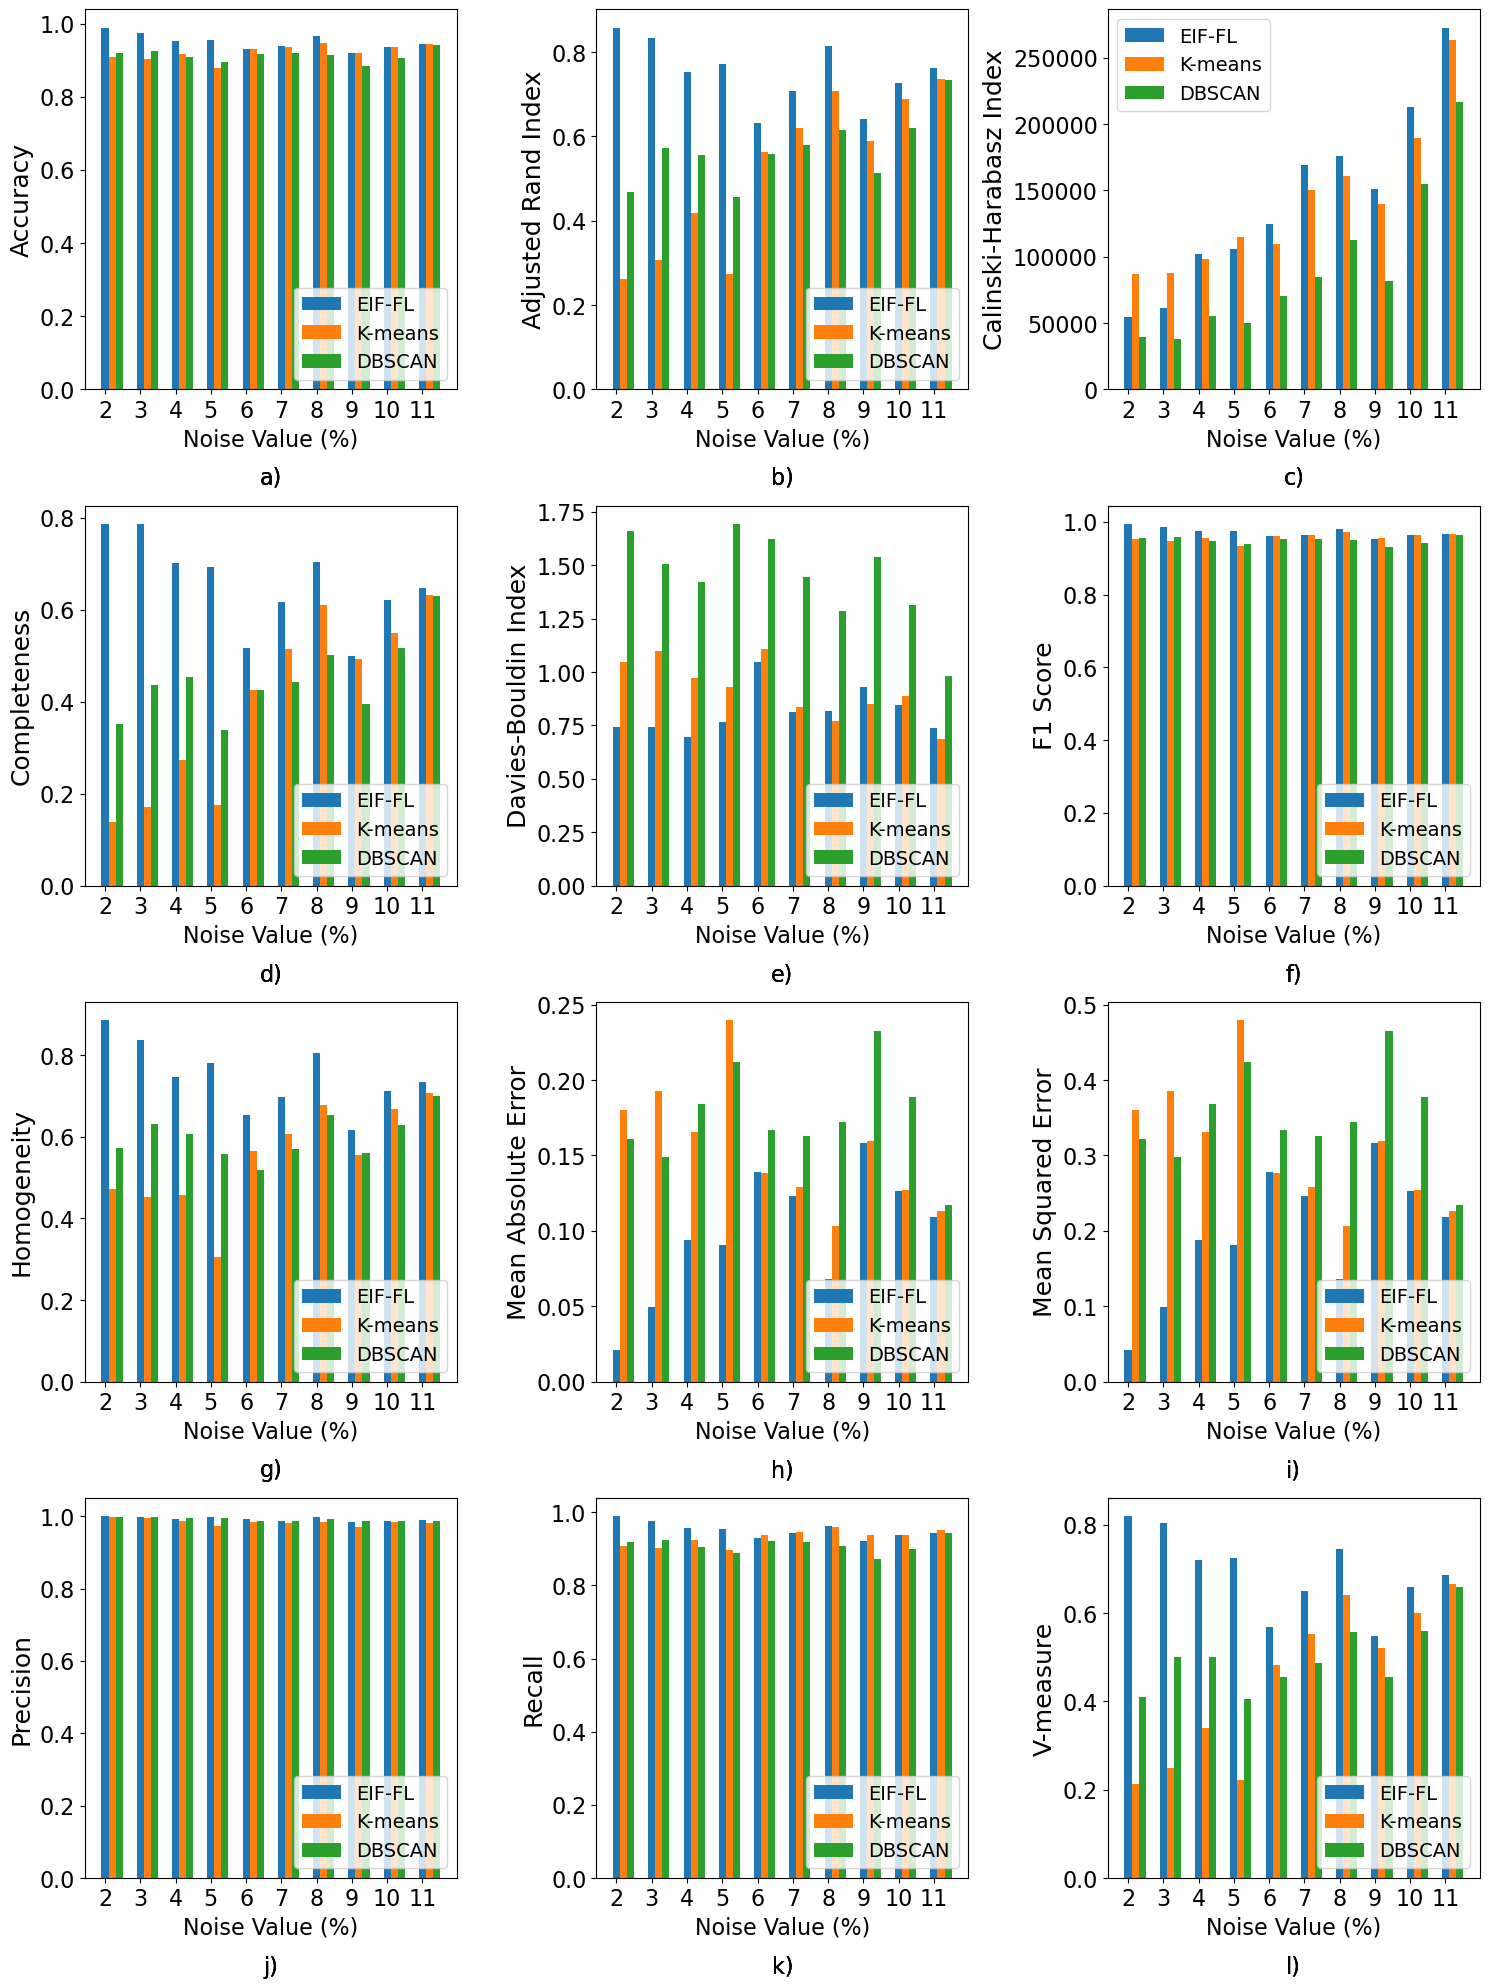

In [ ]:
# Create subplots for each metric
num_rows = 4  # number of rows
num_cols = 3  # number of columns
method_label_mapping = {
    'kmeans': 'K-means',
    'dbscan': 'DBSCAN',
    'ensemble': 'EIF-FL'
}
fig, axes = plt.subplots(num_rows, num_cols, figsize=( 5 * num_cols, 5 * num_rows))
subplot_labels = [f"{chr(97 + i)})" for i in range(num_rows * num_cols)]  # Generate labels: a), b), c), ...

for i,metric_name in enumerate(metric_names):
    metric = {method_p: metrics for method_p, metrics in sorted_metrics.items() if metric_name in metrics}
    row = i // num_cols
    col = i % num_cols
    for method_idx, method in enumerate(method_names):
        ax = axes[row, col] if num_rows > 1 else axes[col]
        p_values = [p + method_idx * 0.2 for (m, p) in metric.keys() if m == method]
        metric_values = [v[metric_name] for (m, p), v in metric.items() if m == method]
        label = method_label_mapping.get(method, method)
        ax.bar(p_values, metric_values, label=label, width=0.2)
        ax.set_xlabel('Noise Value (%)', fontsize=16)
        ax.set_ylabel(metric_name, fontsize=18)
        if i == 2:
            ax.legend(loc='upper left', prop={'size': 14})
        else:
            ax.legend(loc='lower right', prop={'size': 14})
        # plt.xticks([p + (num_methods - 1) * bar_width / 2 for p in set(p_values)], sorted(set(p_values)))
        ax.set_xticks([2,3,4,5,6,7,8,9,10,11])
        ax.text(0.5, -0.25, subplot_labels[i], fontsize=16, ha='center', transform=ax.transAxes)

        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
plt.subplots_adjust(hspace=7)
plt.tight_layout()
plt.show()

## auc roc curve

In [8]:
# Create subplots for each p value
num_p_values = len(set([p for (method, p) in sorted_metrics.keys()]))

KeyError: ('kmeans', 2)

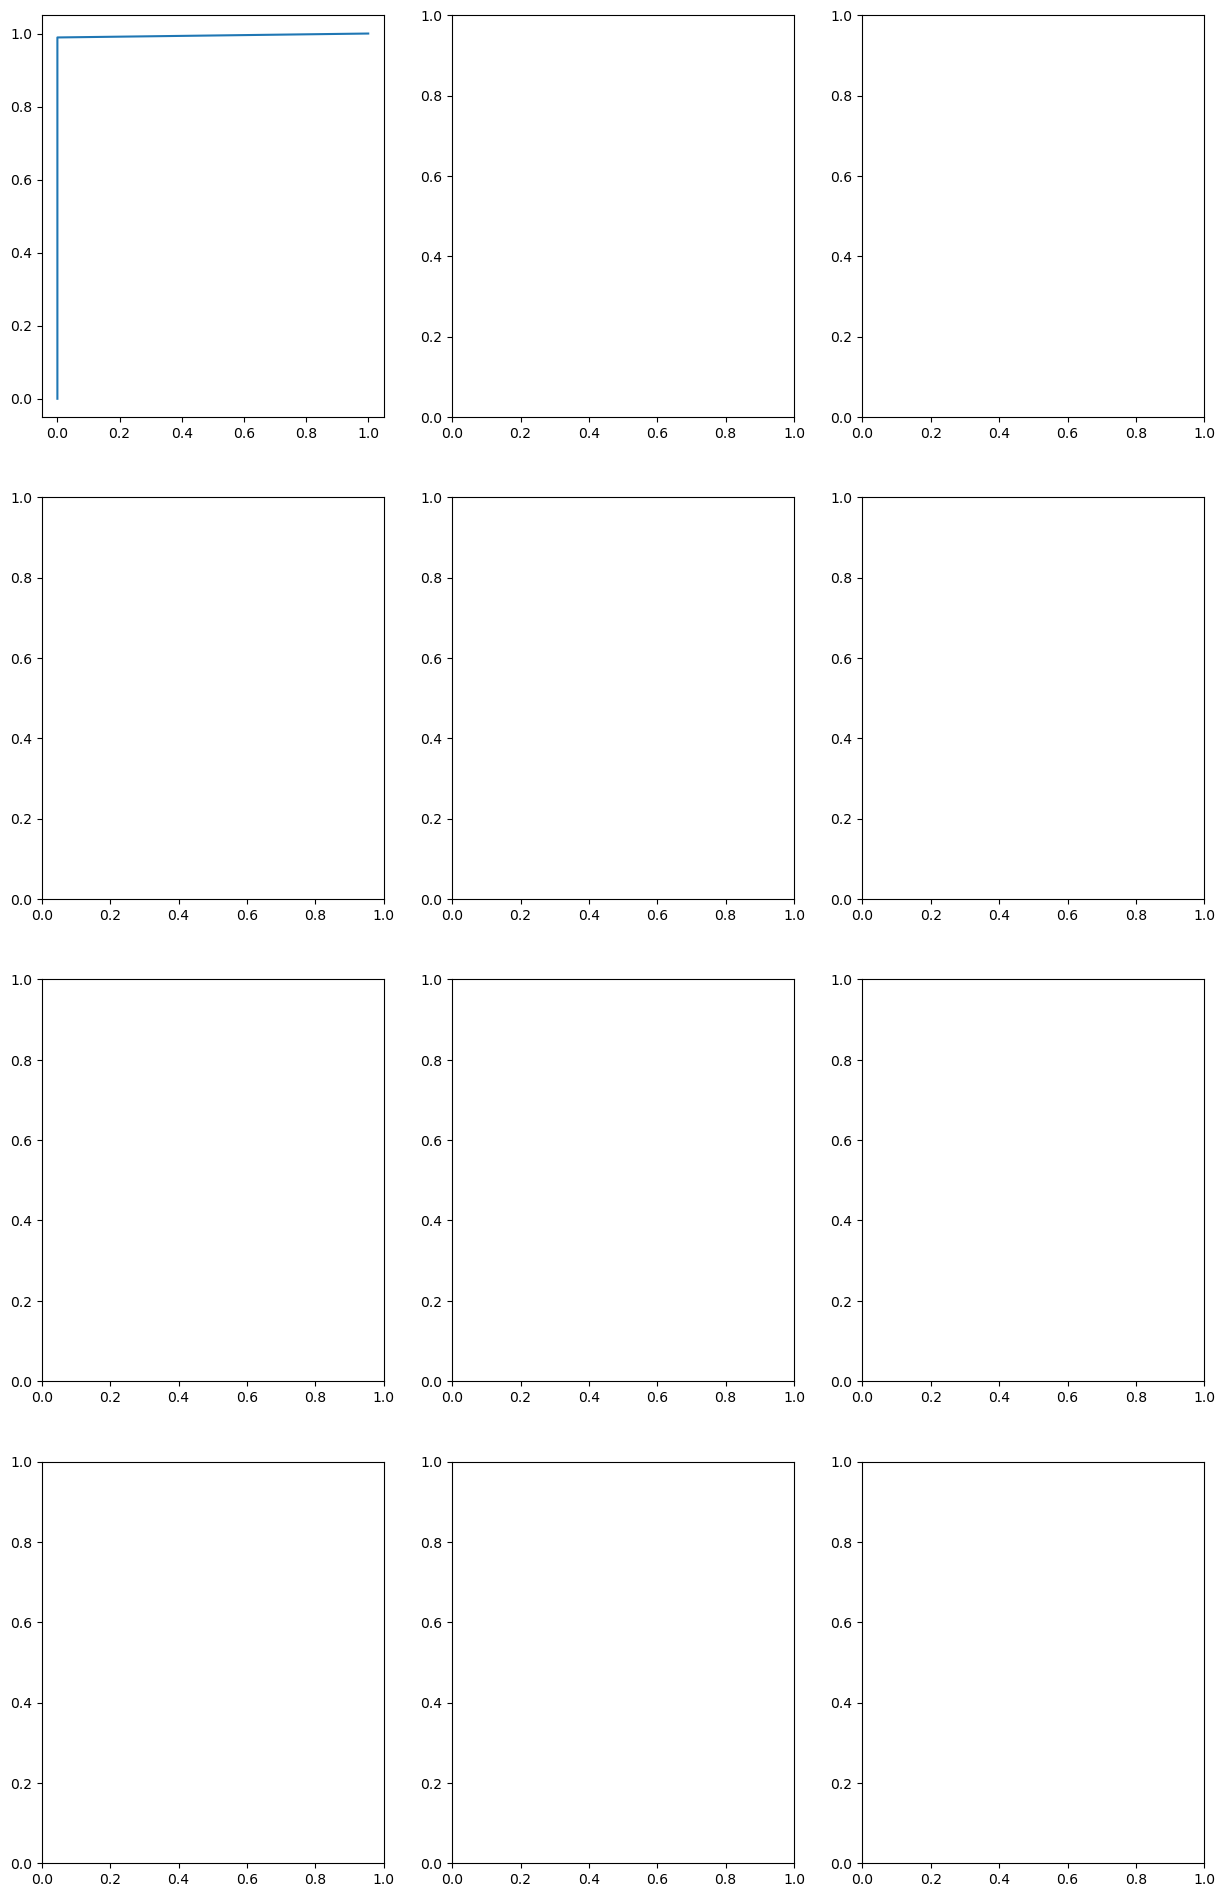

In [12]:

fig, axes = plt.subplots(num_rows, num_cols, figsize=( 5 * num_cols, 6 * num_rows))
subplot_labels = [f"{chr(97 + i)})" for i in range(11)]  # Generate labels: a), b), c), ...

for idx, (p_value, ax) in enumerate(zip(sorted(set([p for (method, p) in sorted_metrics.keys()])), axes.flat)):
    for method in method_names:
        fpr = sorted_metrics[(method, p_value)]['FPR']
        tpr = sorted_metrics[(method, p_value)]['TPR']
        roc_auc = sorted_metrics[(method, p_value)]['ROC AUC']  # Get the single ROC AUC value
        
        # Use the mapping to get the correct label
        label = method_label_mapping.get(method, method)
        ax.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.3f})')

    ax.plot([0, 1], [0, 1], linestyle='--', color='k', label='Random')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate (FPR)', fontsize=16)
    ax.set_ylabel('True Positive Rate (TPR)', fontsize=18)
    ax.set_title(f'ROC Curve (Noise={p_value}%)', fontsize=14)
    ax.legend(loc="lower right", prop={'size': 14})
    ax.text(0.5, -0.20, subplot_labels[idx] +f' Noise={p_value}%', fontsize=16, ha='center', transform=ax.transAxes)

    # Set the font size for x and y ticks
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

# Hide empty subplots if necessary
if num_rows * num_cols > num_p_values:
    for i in range(num_p_values, num_rows * num_cols):
        axes.flat[i].axis('off')

# Adjust the spacing between rows of plots
plt.subplots_adjust(hspace=10)

plt.tight_layout()
plt.show()

# confusion matrix

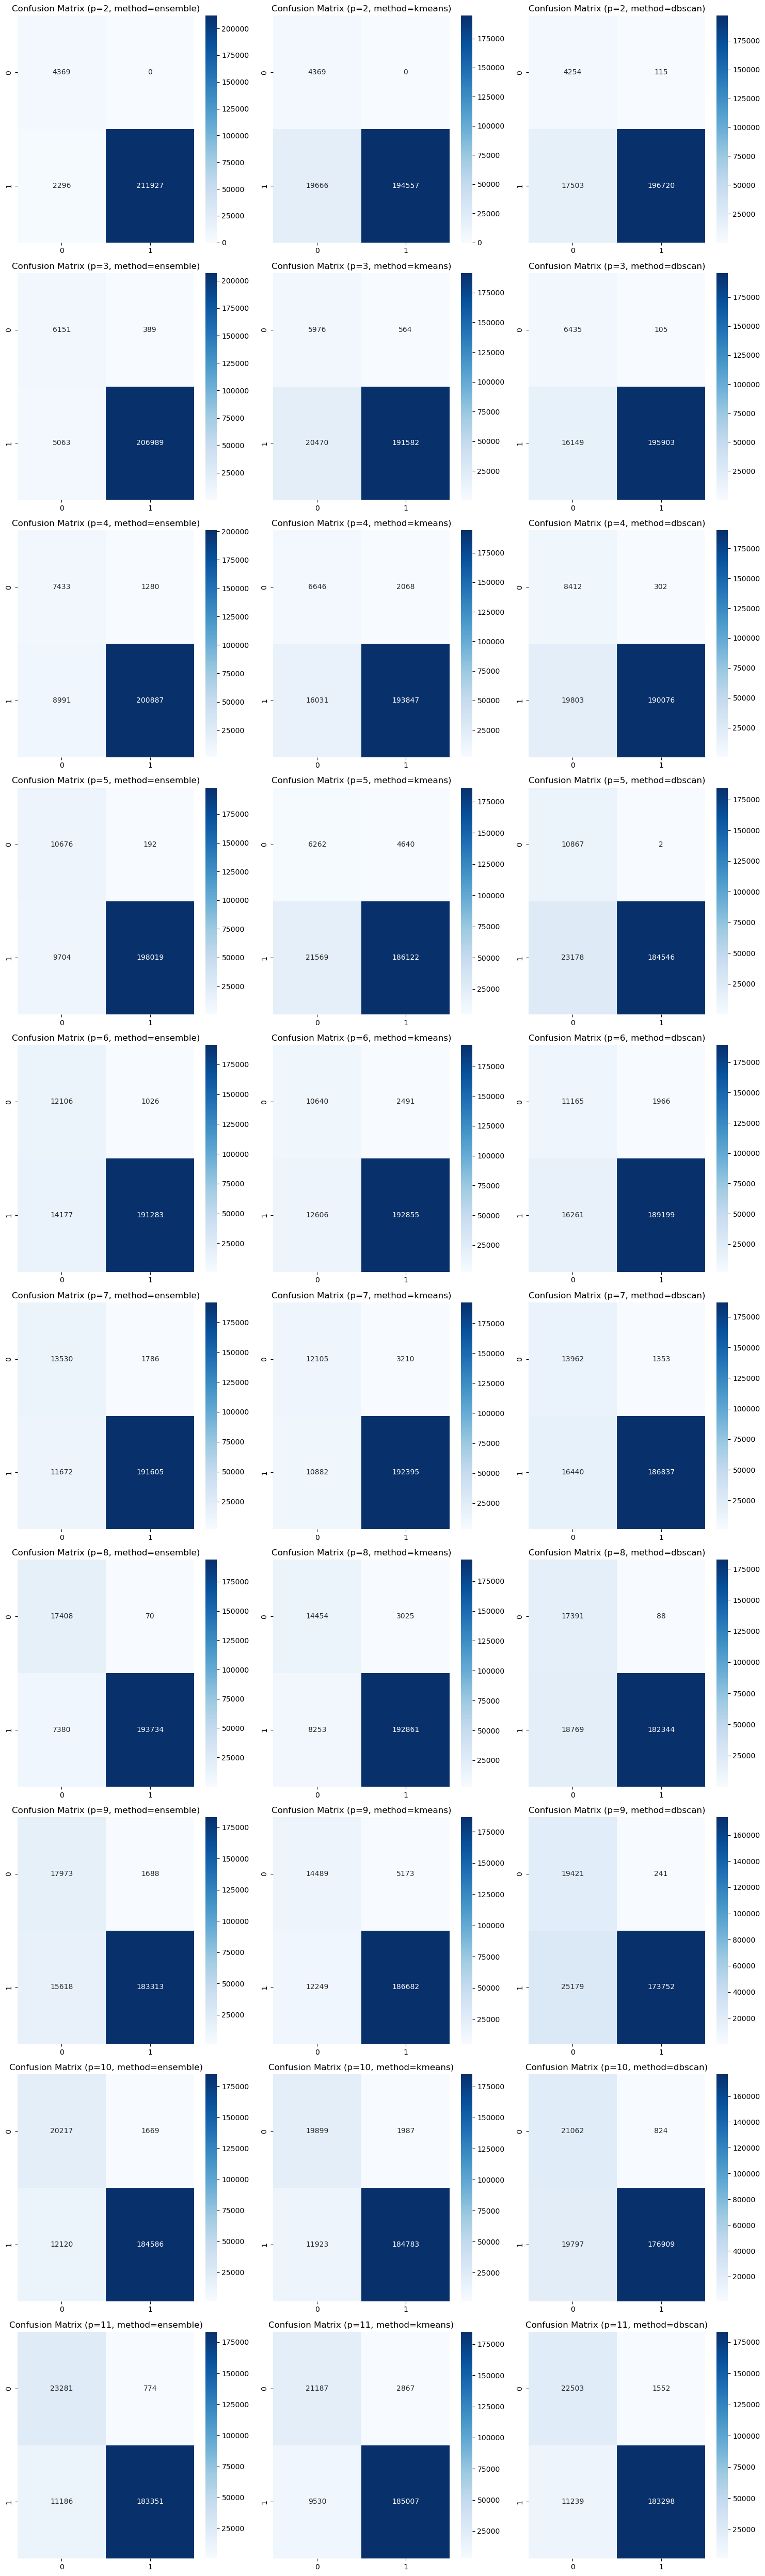

In [19]:
# Create subplots for each p value
num_p_values = len(set([p for (method, p) in sorted_metrics.keys()]))
num_methods = len(method_names)
num_cols = num_methods  # Number of columns for subplots
num_rows = num_p_values  # Number of rows for subplots

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_methods, 5*num_p_values))

for i, (p_value, ax_row) in enumerate(zip(sorted(set([p for (method, p) in sorted_metrics.keys()])), axes)):
    for j, method in enumerate(method_names):
        conf_matrix = np.round(sorted_metrics[(method, p_value)]['Confusion Matrix']).astype(int)
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', ax=ax_row[j])
        ax_row[j].set_title(f'Confusion Matrix (p={p_value}, method={method})')

plt.tight_layout()
plt.show()